# **Métodos Avanzados en Aprendizaje Automático**

## Kernel PCA

*Autores: Mercedes García Villaescusa y Daniel Beteta Francisco*

# Libraries and constants

In [ ]:
import matplotlib
import math

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import KernelCenterer, normalize
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from scipy.sparse.linalg import eigs

In [ ]:
SEED = 123
LINEAR_KERNEL = "linear"
RBF_KERNEL = "rbf"
TITLES = ["Sklearn", "Nuestra implementación"]

# Introduction

This practical assignment consists in implementing a simplified version of the KernelPCA class of `sklearn`.

This class will contain three public methods: `fit()`, `transform()` and `fit_transform()`.

# Implementation of KPCA

## Requirements

The objective of this assignment is to complete the class `KPCA` sketched below, which should contain at least the following methods.

---
```python
__init__(self, n_components, kernel, gamma)
```
* This is the construction method for the class, with the following parameters:
    * `n_components`: Reduced dimension.
    * `kernel`: `'linear'` or `'rbf'`.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$.
* This method should compute the projecting direction, storing the useful information in fields of the class.

---
```python
transform(self, X)
```
* This is the method that computes the projection, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* This method will used the stored information in the class for projecting new points.
---
```python
fit_transform(self, X)
```
* This method firstly fit the model, and latter apply it over the training data, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$.
* **NOTE**: This method can be implemented just calling the methods `fit` and `transform`; but also it can be computed more efficiently by theoretically computing the projection in this case. If this second approach is chosen, a brief explanation of why the implemented code is working will be required.

### Some recommendations:

* We will not pay attention to the dataset size when solving the eigenvector problem, the examples used will be simple ones. We recommend the use of `eigs` from `scipy` that computes only the first `k` eigenvalues and eigenvectors. It will be necessary to ensure that the eigenvectors are ordered in terms of the largest eigenvalues.
* The projection direction should be deterministic, so the eigenvectors finded should be flipped in terms of their sign to obtain always the same result.
* Data should be centered inside the method (so the data has zero mean, but the std remains the same), being careful to also center the new data points.
* Remember that the projection direction should have norm 1. This means that during the training the computed eigenvectors should be properly normalized and stored once normalized.

# Implementation

<div class="qst">

* Complete the `KPCA` class below, satisfying the described requirements.

</div>

In [ ]:
class KPCA():
    def __init__(self, n_components, kernel, gamma=None):
        # Asignación de hiperparámetros
        self.n_components = n_components
        self.kernel = kernel

        if self.kernel=="rbf":
          self.f_kernel = lambda x, y : rbf_kernel(x, y, gamma)
        elif self.kernel=="linear":
          self.f_kernel = lambda x, y: linear_kernel(x, y)


    def fit(self, X):
        self.X_train_std = X
        
        # Obtener el Kernel deseado (sustituye la matriz de covarianzas en PCA)
        K = self.f_kernel(self.X_train_std, self.X_train_std)
        
        # Obtener el Kernel centrado
        self.transformer = KernelCenterer().fit(K)
        K_transformed = self.transformer.transform(K)

        # Obtener los autovalores y autovectores del Kernel (Kernel trick)
        eig_vals, eig_vecs = eigs(K_transformed, self.n_components)
        
        self.eig_vals = eig_vals.real
        eig_vecs = eig_vecs.real

        # Obtener de forma determinista la dirección de los autovectores
        index_of_max_value = np.argmax(np.abs(eig_vecs[:, 0]))
        sign = np.sign(eig_vecs[index_of_max_value])
        eig_vecs_deterministic = eig_vecs * sign
  
        # Obtener los autovectores normalizados 
        self.eig_vecs = eig_vecs_deterministic / np.sqrt(self.eig_vals[0])

        return self

    def transform(self, X):
        self.X_new_std = X
        
        # Crear Kernel con los datos de train y de test
        K = self.f_kernel(self.X_new_std, self.X_train_std)
        
        # Obtener el Kernel centrado
        K_transformed = self.transformer.transform(K)

        # Obtener las projecciones
        self.projections = K_transformed.dot(self.eig_vecs)

        return self.projections

    def fit_transform(self, X):
        # Entrenar el modelo
        self.fit(X)
        
        # Obtener las projecciones
        self.projections = self.eig_vecs.dot(self.eig_vals)
        
        return self.projections

In [ ]:
def plot_projections(title, x_values, y_values, labels):
    plt.title(title)  
    plt.scatter(x_values, y_values, c=labels)
    plt.show()

# Experiments with KPCA

## Comparative with Sklearn PCA

The following cell generates the *blobs* dataset and depicts it.

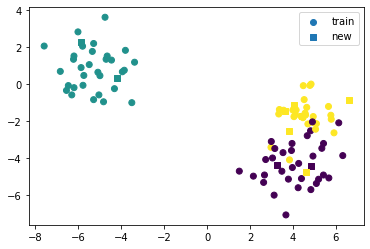

In [ ]:
X, y = make_blobs(random_state=SEED)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]

plt.scatter(X_train[:,0], X_train[:,1],c=y_train, label='train')
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, marker='s', label='new')
plt.legend()
plt.show()

<div class="qst">

* Train and transform a classical PCA model over the training data (`X_train`), using both the implemented `KPCA` class using a linear kernel and the `PCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

### Comprobación del funcionamiento del fit y transform por separado

In [ ]:
# Model definition
model_my = KPCA(n_components=1, kernel=LINEAR_KERNEL)
model_sk = PCA(n_components=1)

# Training of the models 
model_my.fit(X_train)
model_sk.fit(X_train)

PCA(n_components=1)

In [ ]:
# Comparative of the eigenvectors 
eigenvectors_my = model_my.eig_vecs
print("Forma de los autovectores de nuestra implentación {}".format(eigenvectors_my.shape))
print("\nAutovectores de nuestra implentación\n {}".format(eigenvectors_my))

eigenvectors_sk = model_sk.components_
print("\nForma de los autovectores de Scikit Learn {}".format(eigenvectors_sk.shape))
print("\nAutovectores de Scikit Learn\n {}".format(eigenvectors_sk))

Forma de los autovectores de nuestra implentación (90, 1)

Autovectores de nuestra implentación
 [[-0.00170185]
 [-0.00144365]
 [ 0.00315548]
 [-0.00089386]
 [-0.00149731]
 [ 0.00330584]
 [-0.00195384]
 [-0.00101385]
 [-0.00112589]
 [-0.00150643]
 [ 0.00316604]
 [-0.00124488]
 [ 0.00412394]
 [-0.00245382]
 [ 0.00272538]
 [ 0.00323974]
 [-0.00222184]
 [-0.00108122]
 [-0.00136759]
 [ 0.0025524 ]
 [-0.00135725]
 [-0.00138989]
 [-0.0009797 ]
 [ 0.00240797]
 [ 0.00310645]
 [ 0.00323024]
 [ 0.0028349 ]
 [-0.00126455]
 [ 0.00339847]
 [-0.00121293]
 [-0.00204988]
 [-0.00226901]
 [-0.00157906]
 [-0.00179196]
 [-0.00203722]
 [ 0.00329657]
 [ 0.00310401]
 [-0.00159641]
 [-0.00124917]
 [-0.00213565]
 [ 0.00264391]
 [ 0.00227101]
 [ 0.00270032]
 [-0.00115289]
 [-0.00123387]
 [-0.00141198]
 [-0.00198297]
 [ 0.00249343]
 [-0.00164926]
 [ 0.00303186]
 [ 0.00321436]
 [ 0.00287044]
 [ 0.00347081]
 [-0.00196091]
 [ 0.00241332]
 [ 0.00317956]
 [-0.00103468]
 [ 0.00284394]
 [-0.00141369]
 [-0.00121385]
 [-

In [ ]:
# Comparative of the projections (X_new)
projections_my = model_my.transform(X_new)
projections_sk = model_sk.transform(X_new)
projections_pair = [projections_sk, projections_my]

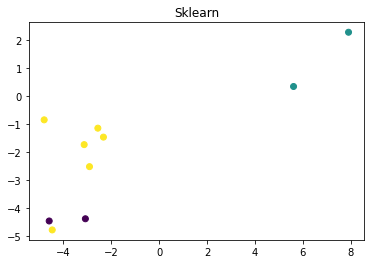

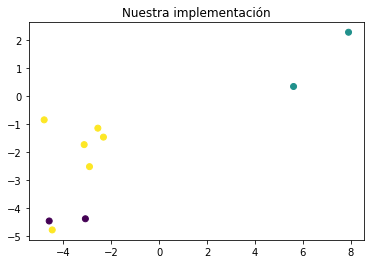

In [ ]:
for title, projections in zip(TITLES, projections_pair):
  plot_projections(title, projections, X_new[:, 1], y_new)

Primero comparamos los resultados en función de los vectores propios. Vemos que en nuestra implementación la forma de los autovectores es (90, 1), mientras que los autovectores de Scikit Learn es (1, 2).

En ambos casos el 1 se corresponde con el número de la dimensión a la que queremos reducir. En Sklearn el 2 será el número de características de los datos del vector de entrada, que al tratarse de la posición en 2 dimensiones será 2. Por otro lado, en nuestro caso los vectores propios son del kernel, que es la matriz de covarianzas, que se construye a partir de los datos de entrenamiento transformados. Al tener 90 observaciones, los vectores propios de dicho kernel tendrán esta dimensión.

También vemos que nosotros escogemos una dirección determinista en función del signo del coeficiente más grande en valor absoluto y aplicamos los cambios pertinentes en el vector propio. Sin embargo, sklearn no aplica esta determinación directamente en los autovectores, ya que observamos que el coeficiente de mayor valor absoluto tiene signo negativo.

Por otro lado, podemos observar las proyecciones de los datos, y que de forma visual parecen coincidir. (Los datos están proyectados en dos dimensiones para facilitar comprobar que nuestro modelo y el que genera sklearn da el mismo resultado para cada dato, ya que si lo comprobásemos en n_components = 1 dimensiones, quedarían los datos solapados).

### Comprobación del funcionamiento del fit_transform

In [ ]:
# Model definition
model_my = KPCA(n_components=1, kernel=LINEAR_KERNEL)
model_sk = PCA(n_components=1)

# Train and transform the models (X_train)
projections_my = model_my.fit_transform(X_train)
projections_sk = model_sk.fit_transform(X_train)
projections_pair = [projections_sk, projections_my]

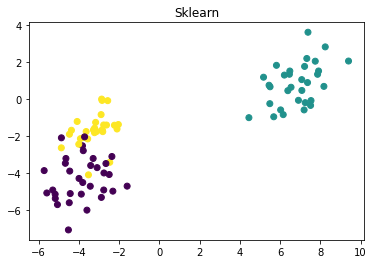

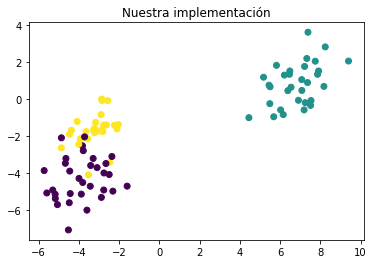

In [ ]:
for title, projections in zip(TITLES, projections_pair):
  plot_projections(title, projections, X_train[:, 1], y_train)

Para el caso concreto en el que queremos hacer un fit() y transform() de los mismo datos, no es necesario llamar a la función fit() y transform() de forma independiente. En este caso la dirección de proyección se puede calcular como
\begin{equation}
K \alpha^T =  \lambda \alpha
\end{equation}

Siendo $K$ el kernel, $\alpha$ los vectores propios de $K$ y $\lambda$ los valores propios de $K$.

## Comparative with Sklearn KernelPCA

<div class="qst">

* Train and transform a Kernel PCA model using a RBF kernel over the training data (`X_train`), calling both the implemented `KPCA` class and the `KernelPCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

### Comprobación del funcionamiento del fit y transform por seperado

In [ ]:
# Model definition
model_my = KPCA(n_components=1, kernel=RBF_KERNEL, gamma=1e-5)
model_sk = KernelPCA(n_components=1)

# Training of the models 
model_my.fit(X_train)
model_sk.fit(X_train)

In [ ]:
# Comparative of the eigenvectors 
eigenvectors_my = model_my.eig_vecs
print("Forma de los autovectores de nuestra implentación {}".format(eigenvectors_my.shape))
print("\nAutovectores de nuestra implentación\n {}".format(eigenvectors_my))

eigenvectors_sk = model_sk.eigenvectors_
print("\nForma de los autovectores de Scikit Learn {}".format(eigenvectors_sk.shape))
print("\nAutovectores de Scikit Learn\n {}".format(eigenvectors_sk))

In [ ]:
# Comparative of the projections (X_new)
projections_my = model_my.transform(X_new)
projections_sk = model_sk.transform(X_new)
projections_pair = [projections_sk, projections_my]

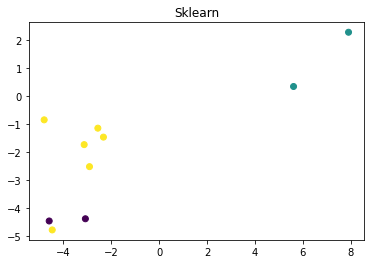

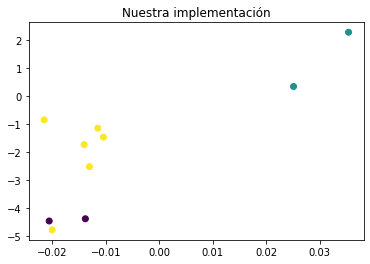

In [ ]:
for title, projections in zip(TITLES, projections_pair):
  plot_projections(title, projections, X_new[:,1], y_new)

Ahora, podemos llegar la mismas conclusiones que en el caso anterior, salvo que ahora el vector propio generado por el modelo de sklearn tiene la misma dimensión que el de nuestro modelo. Vemos que no se genera el mismo vector, pero visualmente en las proyecciones se comprueba que esta diferencia es debido a un factor.

In [ ]:
factor_eigenvectors = [eigenvectors_my[x]/eigenvectors_sk[x] for x in range(len(eigenvectors_my))]
print("El factor (medio) que existe entre los autovectores es", np.mean(factor_eigenvectors))
print("cuya desviación típica será ", np.std(factor_eigenvectors))

El factor (medio) que existe entre los autovectores es 4.686269856277986
cuya desviación típica será  0.0006272168538585444


Vemos entonces que nuestro modelo es coherente con el implementado en sklearn y el factor de cada coeficiente del vector propio es casi idéntico, ya que la desviación típica es pequeña en comparación.

### Comprobación del funcionamiento del fit_transform

In [ ]:
# Model definition
model_my = KPCA(n_components=1, kernel=RBF_KERNEL, gamma=1e-5)
model_sk = KernelPCA(n_components=1)

# Train and transform the models (X_train)
projections_my = model_my.fit_transform(X_train)
projections_sk = model_sk.fit_transform(X_train)
projections_pair = [projections_sk, projections_my]

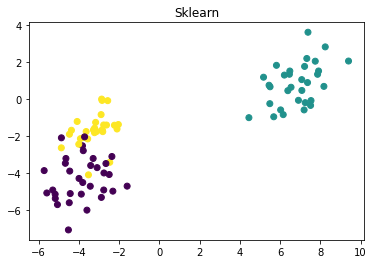

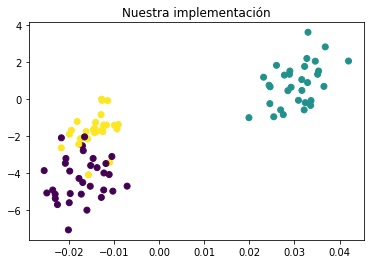

In [ ]:
for title, projections in zip(TITLES, projections_pair):
  plot_projections(title, projections, X_train[:,1], y_train)

En este caso el fit_transform() se comporta como en el caso anterior al comparar el modelo con el PCA.

# Comparing linear kernel against Gaussian kernel

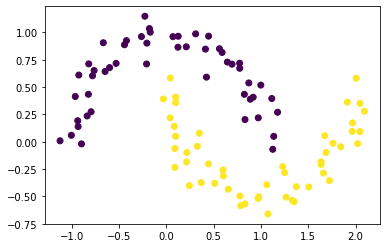

In [ ]:
X, y = make_moons(noise=1e-1, random_state=SEED)

plt.scatter(X[:,0], X[:,1], c=y)

<div class="qst">

* Using the implemented class `KPCA` compare the result of transforming the above dataset using a linear kernel and an RBF one (looking for an appropriated hyperparameter `gamma` value).
* Is there some model able to properly project the classes separately?
</div>

### Linear Kernel

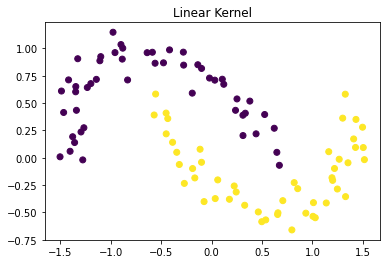

In [ ]:
model_linear = KPCA(n_components=1, kernel=LINEAR_KERNEL)
projections_linear = model_linear.fit_transform(X)
plot_projections("Linear Kernel", projections_linear, X[:,1], y)

### Gaussian Kernel

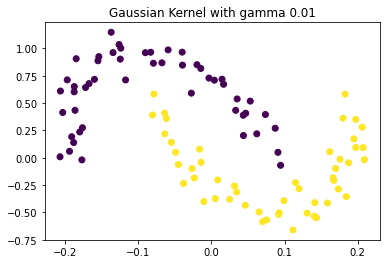

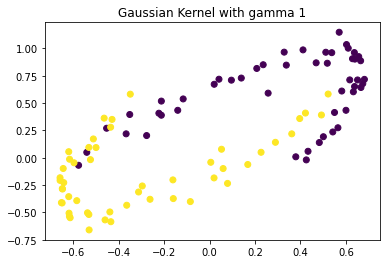

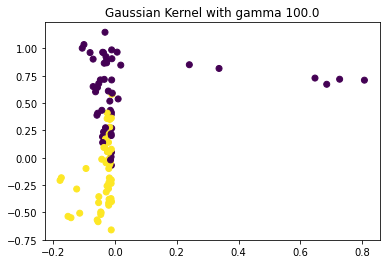

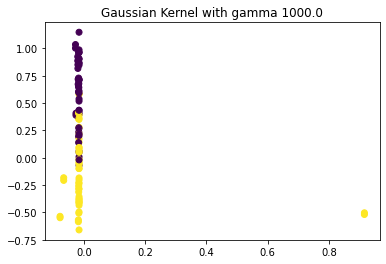

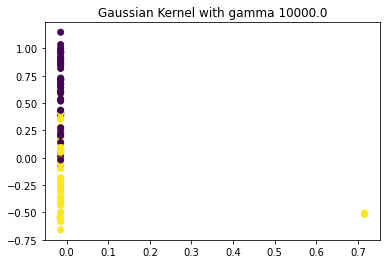

In [ ]:
gammas = [1e-2, 1, 1e2, 1e3, 1e4]

for gamma in gammas:
  model_rbf = KPCA(n_components=1, kernel=RBF_KERNEL, gamma=gamma)
  projections_rbf = model_rbf.fit_transform(X)
  plot_projections("Gaussian Kernel with gamma {}".format(gamma), projections_rbf, X[:,1], y)

Vemos claramente que el Kernel Gaussiano es más apropiado para separar las clases que el lineal en este caso. Esto se debe a la naturaleza del kernel, puesto que se trata de una exponencial, $e^{-\gamma || x-y||}$, de modo que los puntos cercanos son más influyentes. 

Comprobamos además, que la elección del valor del hiperparámetro $\gamma$ puede hacer que el modelo funcione correctamente o que la clasificación funcione de forma casi aleatoria, por lo que la elección del parámetro es parte crucial del problema.